신경망 구성하기
1. 

In [ ]:
import csv
import os
import numpy as np


# 신경망 하이퍼파라미터 설정
input_size = 4096           # 입력 크기: 64x64 이미지의 총 픽셀 수 (4096)
hidden_layers = [2000]  # 은닉층 노드 수
output_size = 111            # 출력층 노드 수: 분류할 클래스 수
learning_rate = 0.005       # 학습률: 가중치 업데이트의 크기
epochs = 100                  # 학습 반복 횟수
batch_size = 10              # 배치 크기: 한 번에 학습할 데이터 수

#데이터 로드 함수 
def load_data(sub_dir, file_name, output_size):
    current_dir = os.getcwd()  # 현재 작업 디렉토리 경로 가져오기
    file_path = os.path.join(current_dir, '한글글자데이터', sub_dir, file_name)   # 데이터 파일 경로

    pixel_data = [] # 픽셀 데이터
    labels = [] # 레이블(정답) 데이터

    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # 문자열을 정수로 변환
            label = int(row[0].strip()) - 1  # 첫 번째 열은 레이블 (0~110), 1을 뺌
            row_data = [float(value) / 255.0 for value in row[1:]]  # 픽셀 데이터 정규화 (0~255 -> 0~1)
            pixel_data.append(row_data)  # 픽셀 데이터를 리스트에 추가

            # 원핫 인코딩 생성
            one_hot_label = [0] * output_size  # 출력 크기만큼 0으로 채운 리스트 생성
            one_hot_label[label] = 1  # 해당 레이블 인덱스를 1로 설정
            labels.append(one_hot_label)  # 원핫 인코딩된 레이블을 리스트에 추가

    # 데이터를 numpy 배열로 변환하여 반환
    return np.array(pixel_data), np.array(labels)


In [70]:
"활성화 함수 정의"

# Relu(순전파 사용)
def relu(x):
    return np.maximum(0, x)  # ReLU 함수: 입력이 0보다 작으면 0, 크면 그대로 출력
# Relu 미분(역전파 사용)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)  # ReLU 미분: 입력이 0보다 크면 1, 작으면 0
# 출력층 활성화함수 정의
def softmax(x):
    exp_x = np.exp(x)  # 입력값 x에 대한 지수 함수 계산
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # softmax: 확률로 변환

In [71]:
"오차 함수 정의"

def MSE(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

In [72]:
"정확도 계산 정의"

def accuracy(y_true, y_pred):
    if y_true.ndim > 1:  
        y_true = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:  
        y_pred = np.argmax(y_pred, axis=1)
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)  # 정확도 계산

In [73]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate):
        self.learning_rate = learning_rate
        # self.drop_rate = drop_rate
        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_layers + [output_size]

        # 각 레이어의 가중치와 편향 초기화
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2.0 / layer_sizes[i])
            bias = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)

    # 순전파 : 입력 데이터를 각 레이어에 전달하여 최종 출력값 계산
    def forward(self, x):
        self.activations = [x]  # 입력 데이터 추가
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            a = relu(z)
            # if training:
            #     a = dropout(a, self.drop_rate)  
            self.activations.append(a)
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.activations.append(a)
        return self.activations[-1]

    # 역전파 : 순전파의 최종 출력값과 실제 레이블 간의 차이를 계산하여 손실 측정
    def backward(self, y_true):
        deltas = [self.activations[-1] - y_true]
        for i in reversed(range(len(self.weights) - 1)):
            delta = deltas[-1].dot(self.weights[i + 1].T) * relu_derivative(self.activations[i + 1])
            deltas.append(delta)
        deltas.reverse()

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.activations[i].T.dot(deltas[i])
            self.biases[i] -= self.learning_rate * np.sum(deltas[i], axis=0, keepdims=True)

    def train(self, x, y, test_data, test_labels, epochs, batch_size,learning_rate=0.0005):
        self.learning_rate = learning_rate
        for epoch in range(epochs):
            if (epoch + 1) % 100 == 0:
                self.learning_rate *= 0.5
            
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            total_loss = 0
            correct_predictions = 0

            for start_idx in range(0, x.shape[0], batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                batch_x = x[batch_indices]
                batch_y = y[batch_indices]

                output = self.forward(batch_x)
                loss = MSE(batch_y, output)
                total_loss += loss

                predictions = np.argmax(output, axis=1)
                true_labels = np.argmax(batch_y, axis=1)
                correct_predictions += np.sum(predictions == true_labels)

                self.backward(batch_y)

            train_accuracy = correct_predictions / x.shape[0] * 100
            average_loss = total_loss / (x.shape[0] // batch_size)

            # 테스트 데이터 정확도 계산
            test_output = self.forward(test_data)
            test_predictions = np.argmax(test_output, axis=1)
            test_true_labels = np.argmax(test_labels, axis=1)
            test_accuracy = accuracy(test_true_labels, test_predictions)

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

    def predict(self, x):
        output = self.forward(x)
        return np.argmax(output, axis=1)

In [74]:
import matplotlib.pyplot as plt

def img_predict(nn, train_data,test_data,train_labels, test_labels,title="Train vs Test (True vs Predicted Images)"):
    # 임의로 10개의 인덱스를 선택하여 학습 데이터와 테스트 데이터에서 이미지와 레이블을 가져옵니다.
    indices = np.random.choice(len(train_data), 10, replace=False)

    plt.figure(figsize=(20, 5))

    for i, idx in enumerate(indices):
        train_image = train_data[idx].reshape(64, 64)  # 학습 데이터의 64x64 크기 이미지
        true_label = np.argmax(train_labels[idx])      # 학습 데이터의 실제 레이블
        

        predicted_label = nn.predict(train_data[idx:idx + 1])[0]  # 학습 데이터 예측

        # 테스트 데이터에서 동일한 레이블을 찾음
        test_idx = next((j for j, label in enumerate(test_labels) if nn.predict(test_data[j:j+1])[0]==predicted_label), None)

        if test_idx is not None:
            test_image = test_data[test_idx].reshape(64, 64)  # 테스트 데이터의 예측 이미지 (노이즈 포함)

        else:
            print(f"No test image found for label {true_label}")
            continue

        # 학습 이미지와 예측된 테스트 이미지 표시
        plt.subplot(2, 10, i * 2 + 1)
        plt.imshow(train_image, cmap='gray')
        plt.title(f"Train True: {true_label}")
        plt.axis('off')

        plt.subplot(2, 10, i * 2 + 2)
        plt.imshow(test_image, cmap='gray')
        plt.title(f"Test Pred: {predicted_label}")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.show()

In [75]:
#데이터 로드
# 데이터 로드
train_data, train_labels = load_data('train', 'train_data.csv', output_size)
test_data, test_labels = load_data('test', 'test_data.csv',output_size)

In [79]:
#신경망 객체 생성 및 학습
# 신경망 객체 생성 및 학습 수행
nn = NeuralNetwork(input_size, hidden_layers, output_size, learning_rate)
nn.train(train_data, train_labels, test_data, test_labels, epochs, batch_size,learning_rate)

Epoch 1/100, Train Loss: 0.0089, Train Accuracy: 1.62%, Test Accuracy: 1.20%
Epoch 2/100, Train Loss: 0.0089, Train Accuracy: 1.89%, Test Accuracy: 1.20%
Epoch 3/100, Train Loss: 0.0089, Train Accuracy: 3.06%, Test Accuracy: 2.40%
Epoch 4/100, Train Loss: 0.0089, Train Accuracy: 5.32%, Test Accuracy: 3.00%
Epoch 5/100, Train Loss: 0.0088, Train Accuracy: 7.57%, Test Accuracy: 3.90%
Epoch 6/100, Train Loss: 0.0087, Train Accuracy: 10.18%, Test Accuracy: 5.11%
Epoch 7/100, Train Loss: 0.0086, Train Accuracy: 14.50%, Test Accuracy: 7.51%
Epoch 8/100, Train Loss: 0.0083, Train Accuracy: 18.20%, Test Accuracy: 6.01%
Epoch 9/100, Train Loss: 0.0080, Train Accuracy: 25.14%, Test Accuracy: 9.91%
Epoch 10/100, Train Loss: 0.0077, Train Accuracy: 29.55%, Test Accuracy: 13.21%
Epoch 11/100, Train Loss: 0.0071, Train Accuracy: 34.95%, Test Accuracy: 14.11%
Epoch 12/100, Train Loss: 0.0068, Train Accuracy: 40.90%, Test Accuracy: 19.22%
Epoch 13/100, Train Loss: 0.0062, Train Accuracy: 46.49%, Test 

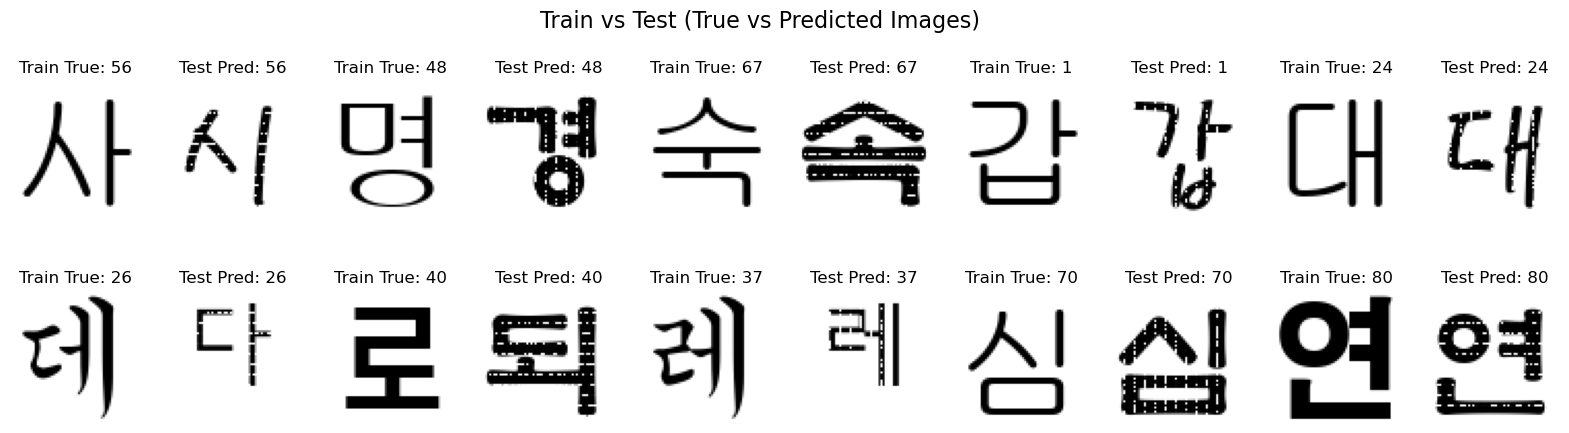

In [77]:
# 학습 데이터에서 10개의 이미지 쌍을 시각화하여 실제 레이블과 예측 레이블의 이미지를 비교
img_predict(nn, train_data, test_data,train_labels,test_labels, title="Train vs Test (True vs Predicted Images)")